<a href="https://colab.research.google.com/github/kimhj010502/ESAA_OB/blob/main/OB_4%EC%A1%B0_%EB%B0%A9%ED%95%99%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. 라이브러리 임포트 및 데이터 로딩**

### **1.1 라이브러리 설치 및 임포트**

In [ ]:
!pip install albumentations==1.2.1
!pip install adabelief-pytorch
!pip install ttach
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import h5py
import cv2
import os
import gc

from typing import Callable, Dict, Sequence, List, Optional, Tuple, Union
from tqdm.auto import tqdm
from glob import glob

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **1.2 데이터 로딩**



In [ ]:
# train 데이터
label_df = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/원본 데이터/train.csv')
train_points = h5py.File('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/원본 데이터/train.h5', 'r')

In [ ]:
# train 데이터의 label 값을 target 변수로 저장
target = label_df['label'].values

In [ ]:
# test 데이터
test_points = h5py.File('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/원본 데이터/test.h5', 'r')

---

## **2. 데이터 파악**

### **2.1 train 데이터 시각화**

In [ ]:
# 3차원 이미지를 시각화하는 함수 정의
def show_3Dimage(
        _3d_points_data: h5py._hl.files.File, 
        id: int, 
        labels: Optional[Sequence] = None
    ) -> None:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    _3d_points = _3d_points_data[str(id)][:]
    x = _3d_points[:, 0]
    y = _3d_points[:, 1]
    z = _3d_points[:, 2]
    ax.scatter(x, y, z, alpha=0.04)

    if labels is not None:
        label = labels[id]
        ax.set_title(label, fontsize=16)
    plt.show()

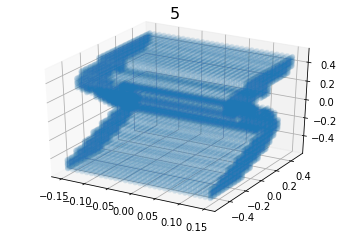

In [ ]:
# 3차원 데이터 시각화(train)
show_3Dimage(train_points, 0, target)

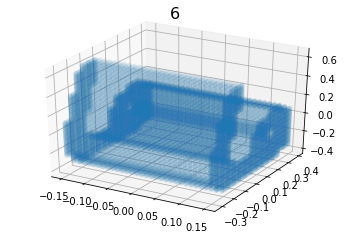

In [ ]:
# 3차원 데이터 시각화(train)
show_3Dimage(train_points, 49977, target)

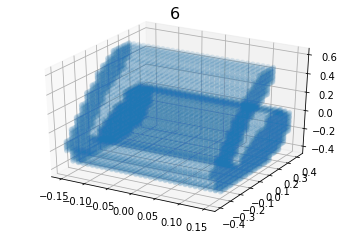

In [ ]:
# 3차원 데이터 시각화(train)
show_3Dimage(train_points, 311, target)

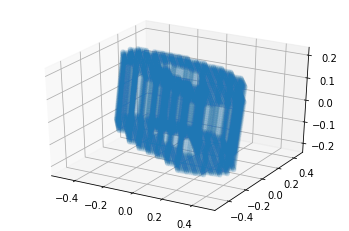

In [ ]:
# 3차원 데이터 시각화(test)
show_3Dimage(test_points, 70000)

### **2.2 train 데이터의 3차원 점들의 분포 확인 (x좌표)**

In [ ]:
x_data = 0
for i in tqdm(range(50000)):
    data = train_points[str(i)][:]
    if 0.14 <= np.max(data[:, 0]) < 0.16 and -0.16 <= np.min(data[:, 0]) <= -0.14:
        x_data += 1

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print(x_data)

50000


### **2.3 train 라벨값 분포 시각화**

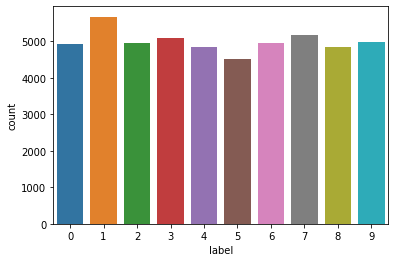

In [ ]:
sns.countplot(data=label_df, x='label')

  - 라벨값은 대체로 균일하게 분포되어 있다.

### **2.4 정리**

  1. `train 데이터`는 `yz 평면의 2차원 이미지`를 `x축 방향으로 연장`시킨 형태이다.
    - 모든 데이터의 x 좌표값이 -0.15 ~ 0.15 사이에 분포하는 것으로 보아, yz 평면의 `2차원 이미지를 x축의 앞뒤로 0.15씩 연장시켜 만든 3차원 이미지`가 train 데이터임을 알 수 있다.

  2. `test 데이터`는 어떤 형태의 3차원 이미지인지 `알 수 없다`. 
    - `원칙적으로는 test 데이터를 확인할 수 없는 상태에서 모델 학습을 진행`하기 때문에, test 데이터가 train 데이터와 동일하게 단순 확장된 3차원 이미지인지 회전된 이미지인지는 알 수 없다.
    - 그러나 `현 대회에서는 test 데이터가 제공`되었으므로, `주어진 test 데이터`를 살펴보면 train 데이터와 달리 `회전된 3차원 이미지`임을 알 수 있다.
    - 다행인 것은 `test 데이터`에 `무작위적인 회전이 일어났다는 것을 제외`하면, train 데이터와 동일한 `단순 확장 3차원 이미지`라는 점이다.

  3. 즉, train 데이터는 2차원 이미지를 3차원으로 단순 확장한 형태이고, test 데이터는 2차원 이미지를 3차원으로 단순 확장한 뒤 무작위로 회전시킨 형태이다.

---

## **3. 데이터 전처리(3D->2D)**
  - 목표
    - 우리가 가진 원본 데이터는 3d points이다.
    - 그러나 `2. 데이터 파악`을 통해 train, test 데이터 모두 2차원 이미지에서 단순 확장된 3차원 이미지임을 확인했다.
    - 따라서 우리는 3d points로 구성된 원본 데이터를 2d points로 변환하고, 이를 다시 2d image로 변환하여 이를 모델 학습에 활용함으로써 사용 가능한 학습 모델의 폭을 넓히고자 한다.

  - 개요 
  1. **3D points -> 2D points**
    - 데이터는 크게 x축 방향으로 -0.15 ~ 0.15만큼 단순 확장된 3차원 이미지(train data)와 그렇지 않은 데이터(test data)로 나뉜다.
    - 전자의 경우 yz 평면에 점들을 정사영시킨다.
    - 후자의 경우 특이값 분해, 고유값 분해, PCA 등의 차원 축소 알고리즘을 활용해 3차원 점들을 2차원 점으로 만든다.

  2. **2D points -> 2D image**
    - size x size 크기의 격자를 만든 뒤, 격자 내부에 해당되는 점의 개수를 픽셀값으로 하여 2D image를 형성한다.
    - 격자의 꼭짓점을 설정할 때는 (xmax, ymax), (xmax, ymin), (xmin, ymax), (xmin, ymin)으로 할 수도 있으나, 이렇게 하면 x축, y축 비율을 1:1로 맞추게 되므로 직사각형 격자가 되어 원본 이미지가 왜곡된다. 
    - 따라서 원본 이미지를 왜곡하지 않도록 (zmax, zmax), (zmax, zmin), (zmin, zmax), (zmin, zmin)으로 설정하여 정사각형 격자를 형성하도록 함으로써 원본 이미지가 왜곡되는 것을 방지한다.

  3. **3D points -> 2D points -> 2D image**
    - 위의 과정을 한 번에 진행하는 함수를 활용해 train, test 데이터를 3d points에서 2d image로 변환한다.
    - 마지막으로 변환된 2d image를 시각화하여 확인한다.

### **3.1 3D points -> 2D points**

- **Method 1. 정사영 (x값의 범위가 -0.15 ~ 0.15를 만족하는 경우)**

In [ ]:
def projection(_3d_points: npt.NDArray) -> Union[npt.NDArray, None]:
    """yz평면에 숫자를 생성하고 x축으로 팽창시킨 경우 (x축의 범위: -0.15 ~ 0.15) 
    yz평면에 3차원 점들을 정사영
    """
    x = _3d_points[:, 0]
    y = _3d_points[:, 1]
    z = _3d_points[:, 2]
    xmax = np.max(x)
    xmin = np.min(x) 

    if not (0.14 <= xmax <= 0.16 and -0.16 <= xmin <= -0.14):
        return None

    _2d_points = np.column_stack((y, z))
    return _2d_points

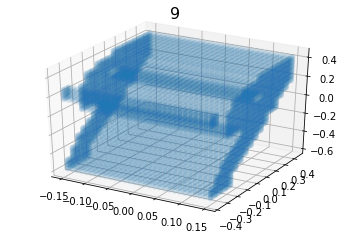

In [ ]:
show_3Dimage(train_points, 41483, target)

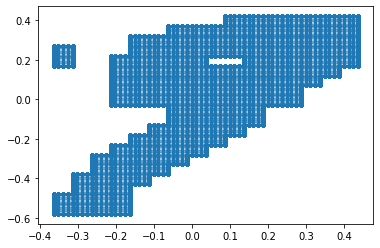

In [ ]:
z = projection(train_points['41483'][:])
plt.plot(z[:, 0], z[:, 1], '.')
plt.show()

  - **Method 2. 차원 축소 알고리즘을 활용해 3차원 점들을 2차원 점들로 축소 (x값의 범위가 -0.15 ~ 0.15를 만족하지 않는 경우)**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def z_scale(_3d_points: npt.NDArray) -> npt.NDArray:
    """_3d_points == [[x1, y1, z1], [x2, y2, z2], ..., [xn, yn, zn]]"""
    scaled_points = []

    for i in range(3):
        p = _3d_points[:, i]
        pp = (p - np.mean(p)) / np.std(p)
        scaled_points.append(pp)

    scaled_points = np.column_stack(tuple(scaled_points))
    return scaled_points

In [ ]:
# SVD를 활용해 3D points를 2D points로 차원 축소하는 함수 정의
def svd_3d_to_2d(_3d_points: npt.NDArray) -> npt.NDArray:
    """SVD를 이용하여 3차원 점을 2차원 점으로 차원 축소"""
    X = _3d_points
    U, d, V = np.linalg.svd(X.T @ X)
    V_tilde = np.column_stack((-V[:, 1], -V[:, 0]))  ## 각도 조절
    _2d_points = X @ V_tilde
    return _2d_points

In [ ]:
# 고유값 분해를 활용해 3D points를 2D points로 차원 축소하는 함수 정의
def eig_3d_to_2d(_3d_points: npt.NDArray) -> npt.NDArray:
    """고유값 분해를 이용하여 3차원 점을 2차원 점으로 차원 축소"""
    X = _3d_points
    Lambda, Psi = np.linalg.eig(X.T @ X)
    _1st, _2nd, _3rd = sorted(Lambda, key = lambda x: -x)  ## 내림차순 정렬
    idx_1st = np.where(Lambda == _1st)
    idx_2nd = np.where(Lambda == _2nd)
    
    Psi_tilde = np.column_stack((-Psi[:, idx_2nd].squeeze(), -Psi[:, idx_1st].squeeze()))  ## 각도 조절
    _2d_points = X @ Psi_tilde
    return _2d_points

In [ ]:
# 특이값 분해, 고유값 분해, PCA를 각각 수행해 시각화하는 함수 정의
def show_2Dimages(
        _3d_points_data: h5py._hl.files.File, 
        id: int, 
        scaling: bool = False
    ) -> None:
    """3D 이미지에 특이값 분해(SVD), 고유값 분해, PCA를 각각 수행하고 시각화"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
    pca = PCA(n_components=2)

    X = _3d_points_data[str(id)][:]
    if scaling:
        X = z_scale(X)

    svd_z = svd_3d_to_2d(X)
    eig_z = eig_3d_to_2d(X)
    pca_z = pca.fit_transform(X)

    ax1.plot(svd_z[:,0], svd_z[:,1], '.', alpha=0.5)
    ax2.plot(eig_z[:,0], eig_z[:,1], '.', alpha=0.5)
    ax3.plot(pca_z[:,0], pca_z[:,1], '.', alpha=0.5)

    ax1.set_title('SVD')
    ax2.set_title('Eigen')
    ax3.set_title('PCA')
    plt.show()    

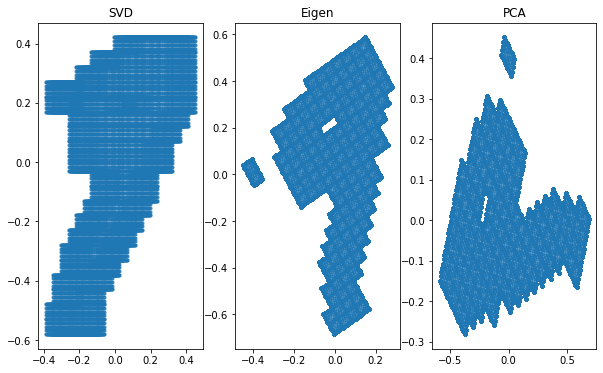

In [ ]:
# 2D points 출력
show_2Dimages(train_points, 41483)

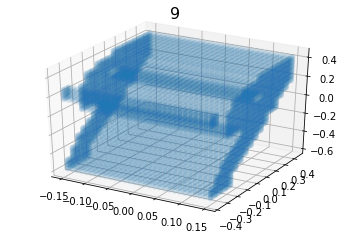

In [ ]:
# 실제 3D 이미지와 비교
show_3Dimage(train_points, 41483, target)

  - 실제 target 값과 비교한 결과, 고유값 분해가 원본 이미지를 가장 잘 보존하는 것으로 보인다.
  - PCA 역시 원본 이미지를 잘 보존하나 회전되어 나타나므로, 차원 축소 알고리즘 중에서는 고유값 분해가 가장 적절하다.

### **3.2 2D points -> 2D image**

  - **Step 1. 2차원 점들을 정사각형 형태로 출력**

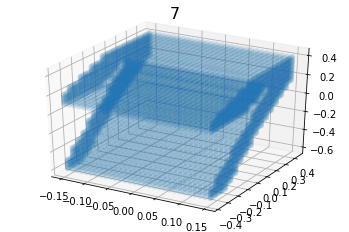

In [ ]:
# 원본 이미지
show_3Dimage(train_points, 71, target)

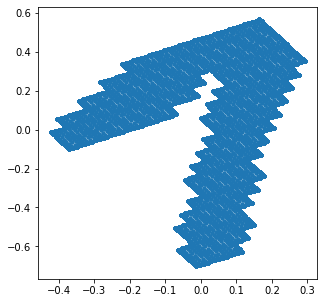

In [ ]:
# x, y 범위를 지정하지 않고 출력 (xmax, xmin, ymax, ymin을 꼭짓점으로 설정)
z = eig_3d_to_2d(train_points['71'][:])
plt.figure(figsize=(5, 5))
plt.plot(z[:, 0], z[:, 1], '.')
plt.show()

  - x, y 범위를 지정하지 않고 출력하면 xmax, xmin, ymax, ymin이 네 개의 꼭짓점이 되므로 위와 같은 직사각형 형태의 이미지가 생성된다.
  - 그러나 우리는 최종적으로 x, y축이 갖는 원본 비율에 관계없이 정사각형의 형태로 이미지를 출력해야 한다.
  - 따라서 네 꼭짓점을 직사각형이 아닌 정사각형으로 설정하여 원본 이미지의 왜곡을 방지한다.

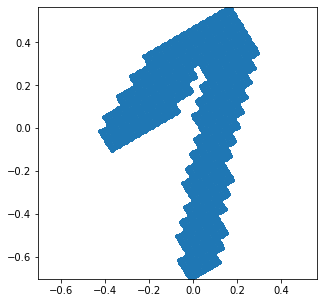

In [ ]:
# x, y 범위를 정사각형으로 지정하여 출력 (zmax, zmin을 꼭짓점으로 설정)
z = eig_3d_to_2d(train_points['71'][:])
plt.figure(figsize=(5, 5))
plt.plot(z[:, 0], z[:, 1], '.')
plt.xlim(np.min(z), np.max(z))
plt.ylim(np.min(z), np.max(z))
plt.show()

  - 이미지가 정사각형 형태로 잘 출력되었다.
  - 위와 같이 이미지가 약간 잘리는 것을 해결하기 위해 약간의 여백을 삽입한다.

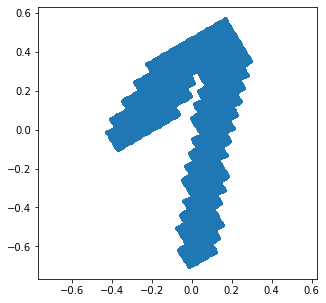

In [ ]:
# x, y 범위를 지정하여 정사각형 형태로 출력되도록 설정 (zmax, zmin을 꼭짓점으로 설정)
z = eig_3d_to_2d(train_points['71'][:])
delta = (np.max(z) - np.min(z)) * 0.05  ## 상하좌우 각각에 축 범위의 5% 만큼 여백을 삽입
plt.figure(figsize=(5, 5))
plt.plot(z[:, 0], z[:, 1], '.')
plt.xlim(np.min(z) - delta, np.max(z) + delta)
plt.ylim(np.min(z) - delta, np.max(z) + delta)
plt.show()

  - **Step 2. 점을 중앙으로 평행이동**
    - 이미지를 중앙으로 정렬하지 않으면 여백의 밸런스가 일정하지 않아 모델 학습에 방해가 될 수 있으므로, 점들을 중앙으로 정렬한다.
    - 점을 중앙으로 정렬한다는 것은 좌우의 여백을 같게 하고 상하의 여백을 같게 하는 것과 동일하다.

In [ ]:
# 점을 중앙으로 정렬하는 함수 정의
def move_points_to_center(
        _2d_points: npt.NDArray, 
        pmax: float, 
        pmin: float, 
        xmax: float, 
        xmin: float, 
        ymax: float, 
        ymin: float,
        deepcopy: bool = True
    ) -> npt.NDArray:
    """_2d_points == [[x1, y1], [x2, y2], ..., [xn, yn]] 
    pmax == max([xmax, ymax]), pmin == min([xmin, ymin])
    (pmax, pmax), (pmax, pmin), (pmin, pmax), (pmin, pmin)을 네 점으로 하는 사각형을 기준으로 하여
    정사각형 내부에 존재하는 points를 중앙으로 평행이동
    """
    if pmax < xmax or pmax < ymax or pmin > xmin or pmin > ymin:
        return _2d_points

    if deepcopy:
        _2d_points = _2d_points.copy()

    left_right_blank = ((pmax - xmax) + (xmin - pmin)) / 2  ## 좌우 여백
    up_down_blank = ((pmax - ymax) + (ymin - pmin)) / 2  ## 상하 여백
    _2d_points[:, 0] += ((pmax - xmax) - left_right_blank)
    _2d_points[:, 1] += ((pmax - ymax) - up_down_blank)
    return _2d_points

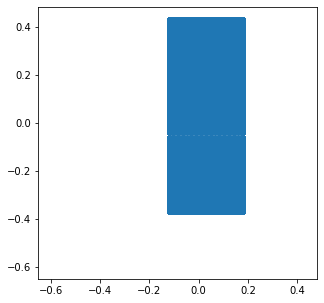

In [ ]:
x = train_points['71'][:, 0]
y = train_points['71'][:, 1]
xmax = np.quantile(x, 0.99)
xmin = np.quantile(x, 0.01)
ymax = np.quantile(y, 0.99)
ymin = np.quantile(y, 0.01)
pmax = np.max([xmax, ymax])
pmin = np.min([xmin, ymin])

z = move_points_to_center(train_points['71'][:], pmax, pmin, xmax, xmin, ymax, ymin)
delta = (np.max(z) - np.min(z)) * 0.05
plt.figure(figsize = (5, 5))
plt.plot(z[:, 0], z[:, 1], '.')
plt.xlim(np.min(z) - delta, np.max(z) + delta)
plt.ylim(np.min(z) - delta, np.max(z) + delta)
plt.show()

  - **Step 3. 2차원 점들을 2차원 이미지로 변환하는 최종 코드**

In [ ]:
# 2차원 점들을 2차원 이미지로 변환하는 함수 정의
def points2image(
        _2d_points: npt.NDArray, 
        x_y: Tuple[int, int] = (28, 28),
        deepcopy: bool = True
    ) -> npt.NDArray:
    """_2d_points == [[x1, y1], [x2, y2], ..., [xn, yn]] 
    (x_y[0], x_y[1]) 크기의 격자를 만들고 칸 하나를 픽셀로 생각하여 이미지를 생성
    픽셀값은 해당 칸에 존재하는 점의 개수로 설정 
    """
    assert x_y[0] == x_y[1], 'x_y[0] and x_y[1] must be the same'
    q = 0.01
    x = _2d_points[:, 0]
    y = _2d_points[:, 1]
    xmax = np.quantile(x, 1 - q)
    xmin = np.quantile(x, q)
    ymax = np.quantile(y, 1 - q)
    ymin = np.quantile(y, q)
    pmax = np.max([xmax, ymax])
    pmin = np.min([xmin, ymin])

    ## 이미지의 상하좌우에 공백을 삽입
    ratio = 0.05
    delta = np.abs(pmax - pmin) * ratio
    pmax += delta
    pmin -= delta

    ## 이미지를 중앙으로 평행이동
    centered_2d_points = move_points_to_center(_2d_points, pmax, pmin, xmax, xmin, ymax, ymin, deepcopy)
    x = centered_2d_points[:, 0]  ## 가로
    y = centered_2d_points[:, 1]  ## 세로

    ## (pmax, pmax), (pmax, pmin), (pmin, pmax), (pmin, pmin)을 네 점으로 하는 사각형 생성
    ## 해당 사각형을 x_y 크기의 격자로 만들고 칸 하나를 픽셀로 생각하여 이미지를 생성
    nx, ny = x_y[0] + 2, x_y[1] + 2
    x_linspace = np.linspace(pmin, pmax, x_y[0]+1)  ## 0 ~ x_y[0]
    y_linspace = np.linspace(pmin, pmax, x_y[1]+1)  ## 0 ~ x_y[1]
    x_idx = np.searchsorted(x_linspace, x)              
    y_idx = ny - np.searchsorted(y_linspace, y) - 1    

    ## 이미지 생성
    xy_idx = x_idx + nx*y_idx   ## 2차원 배열을 1차원 배열로 변경했을 때의 인덱스
    image_shape = nx * ny
    vector = np.bincount(xy_idx, minlength=image_shape)
    image = vector.reshape(ny, nx)

    ## 노이즈 제거
    ixgrid = np.ix_(range(1, nx-1), range(1, ny-1))
    image = image[ixgrid]
    return image

  - 최종 결과 확인

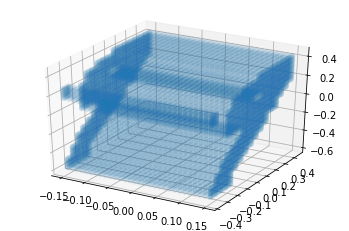

In [ ]:
# 원본 이미지 (3D points)
show_3Dimage(train_points, 41483)

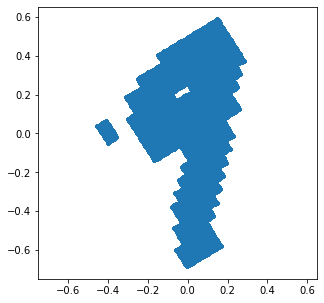

In [ ]:
# 3D points -> 2D points
z = eig_3d_to_2d(train_points['41483'][:])
delta = (np.max(z) - np.min(z)) * 0.05  ## 상하좌우 각각에 축 범위의 5% 만큼 여백을 삽입
plt.figure(figsize=(5, 5))
plt.plot(z[:, 0], z[:, 1], '.')
plt.xlim(np.min(z) - delta, np.max(z) + delta)
plt.ylim(np.min(z) - delta, np.max(z) + delta)
plt.show()

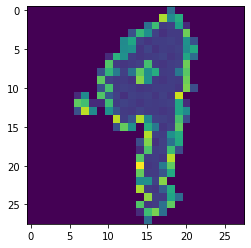

In [ ]:
# 2D points -> 2D image
image = points2image(z, x_y=[28, 28])  
plt.imshow(image)

### **3.3 3차원 점들을 2차원 점들을 거쳐 2차원 이미지로 최종 변환**

In [ ]:
# 3차원 점들로부터 2차원 점들로 차원 축소한 뒤, 이를 활용해 2차원 이미지를 생성하는 함수
def get_2d_images(
        _3d_points_data: h5py._hl.files.File, 
        ids: Sequence[int],
        x_y: Tuple[int, int] = (28, 28)
    ) -> npt.NDArray:   
    images = []
    for id in tqdm(ids):
        _3d_points = _3d_points_data[str(id)][:]
        _2d_points = projection(_3d_points)  ## yz평면에 정사영

        if _2d_points is None:
            _2d_points = eig_3d_to_2d(_3d_points)  ## 고유값 분해를 통한 차원 축소

        _2d_image = points2image(_2d_points, x_y, deepcopy=False)  ## 2D points -> 2D image
        images.append(_2d_image)
    images = np.array(images, dtype=np.float32)
    return images

In [ ]:
# train 데이터 변환
train_images = get_2d_images(train_points, range(50000))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print(train_images.shape)

(50000, 28, 28)


In [ ]:
# test 데이터 변환
test_images = get_2d_images(test_points, range(50000, 90000))

  0%|          | 0/40000 [00:00<?, ?it/s]

In [ ]:
print(test_images.shape)

(40000, 28, 28)


### **3.4 최종 완성된 2D image 시각화**

In [ ]:
def show_random_images(
        images: npt.NDArray,
        labels: npt.NDArray[np.int_], 
        label_condition: Optional[int] = None,
        nrows: int = 4, 
        ncols: int = 4
    ) -> None:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2, nrows*2))
    if label_condition is not None:
        images = images[labels == label_condition].copy()
        labels = labels[labels == label_condition].copy() 
    idx_list = list(map(int, np.random.uniform(size=nrows*ncols) * images.shape[0]))

    for idx, ax in zip(idx_list, axs.flatten()):
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(labels[idx])
        ax.imshow(images[idx])       
    fig.tight_layout()

  - train 데이터

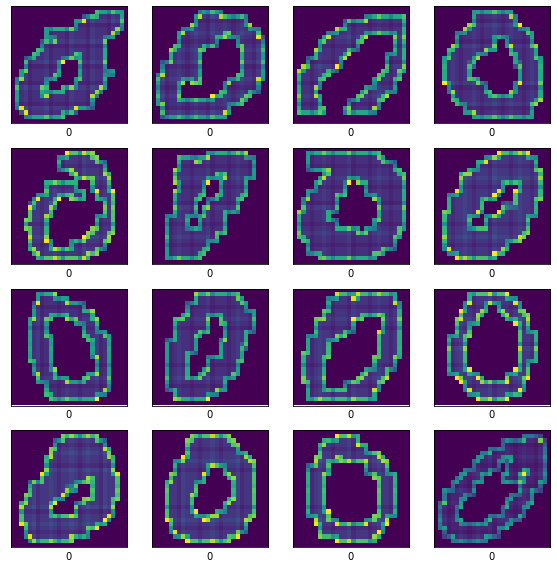

In [ ]:
# 숫자 0 이미지
show_random_images(train_images, target, 0)

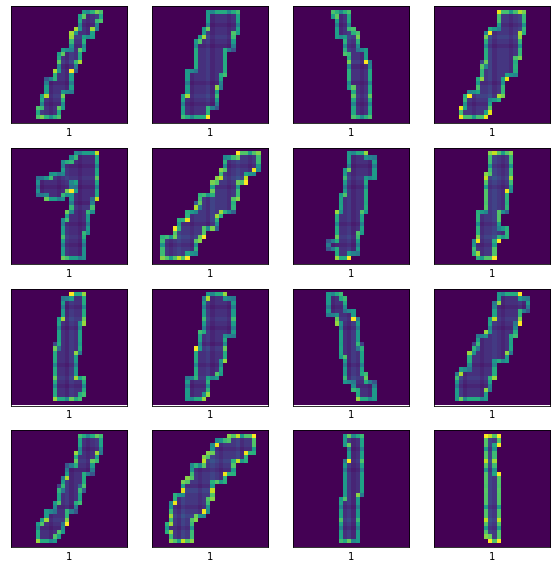

In [ ]:
# 숫자 1 이미지
show_random_images(train_images, target, 1)

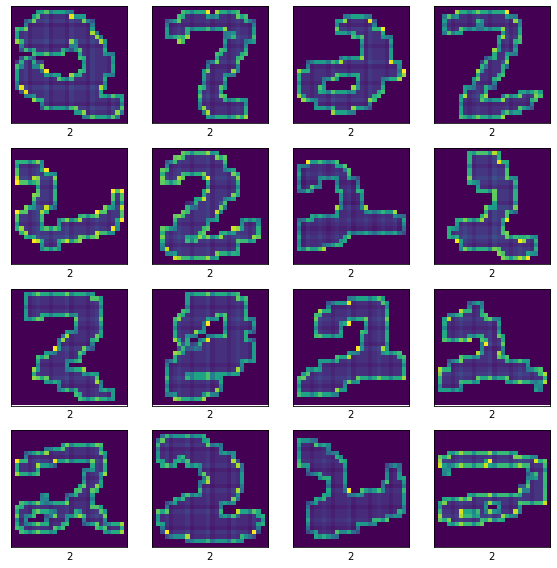

In [ ]:
# 숫자 2 이미지
show_random_images(train_images, target, 2)

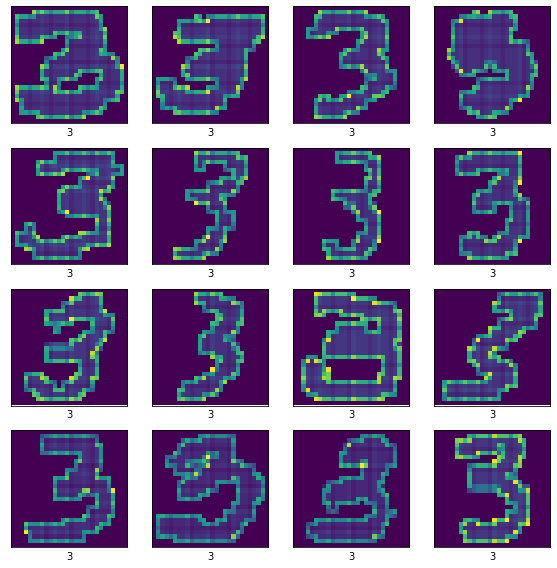

In [ ]:
# 숫자 3 이미지
show_random_images(train_images, target, 3)

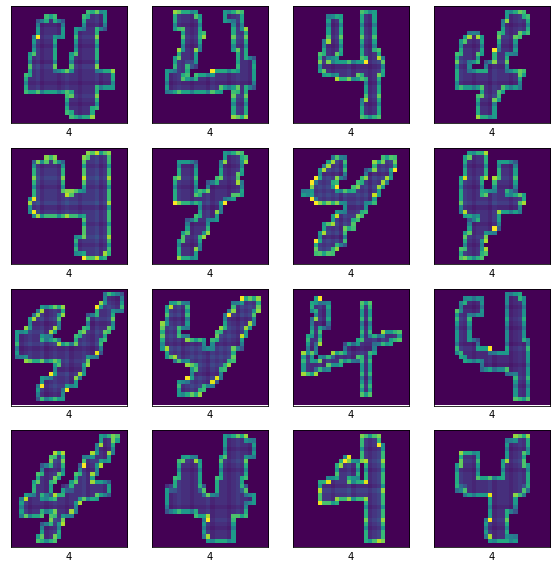

In [ ]:
# 숫자 4 이미지
show_random_images(train_images, target, 4)

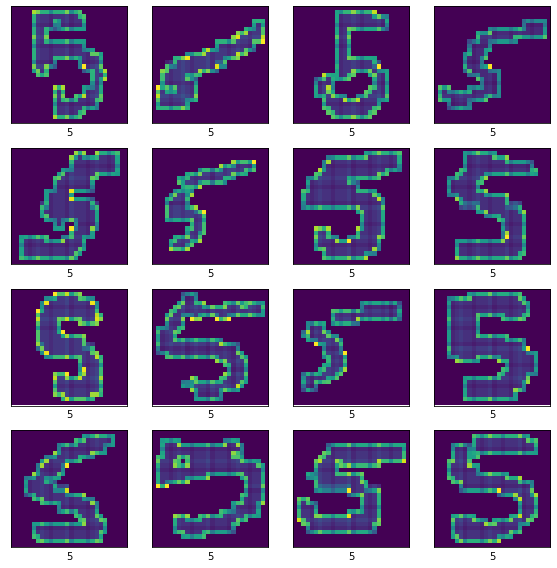

In [ ]:
# 숫자 5 이미지
show_random_images(train_images, target, 5)

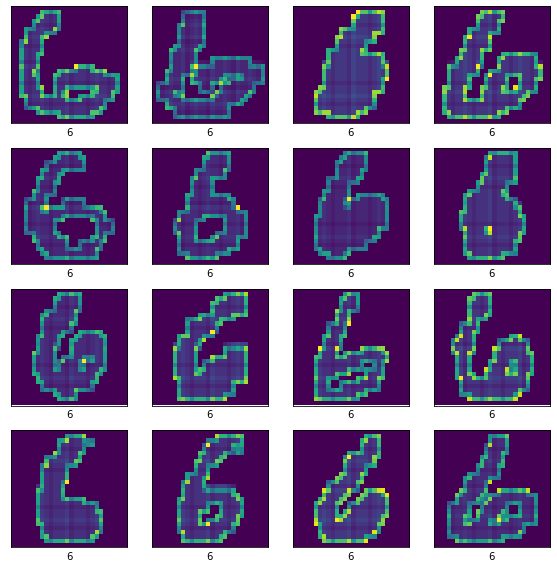

In [ ]:
# 숫자 6 이미지
show_random_images(train_images, target, 6)

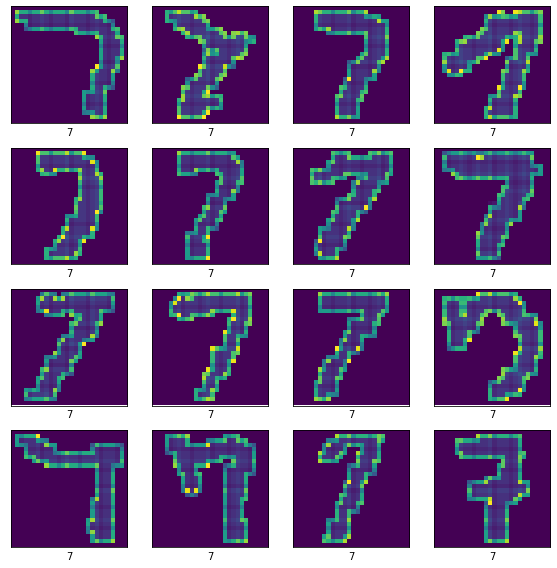

In [ ]:
# 숫자 7 이미지
show_random_images(train_images, target, 7)

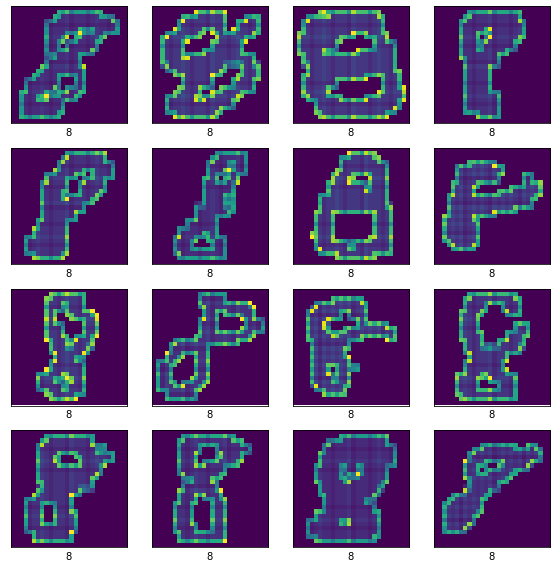

In [ ]:
# 숫자 8 이미지
show_random_images(train_images, target, 8)

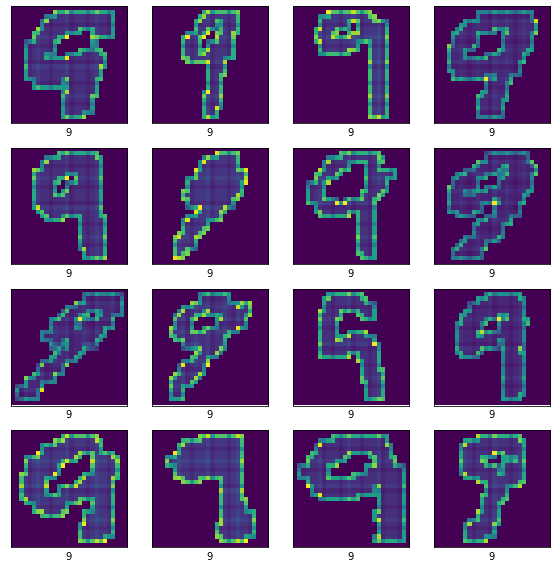

In [ ]:
# 숫자 9 이미지
show_random_images(train_images, target, 9)

  - test 데이터

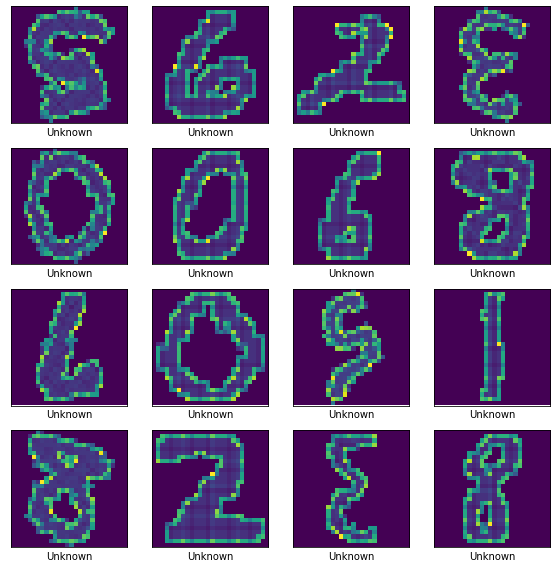

In [ ]:
show_random_images(test_images, ['Unknown'] * 40000)

### **3.5 2차원 이미지를 벡터로 변환 후 csv 파일로 저장**

In [ ]:
train_vectors = train_images.reshape(-1, 28*28)
test_vectors = test_images.reshape(-1, 28*28)

In [ ]:
print(train_vectors.shape, test_vectors.shape)

(50000, 784) (40000, 784)


In [ ]:
train_data = pd.DataFrame([])
train_data['ID'] = list(range(50000))

test_data = pd.DataFrame([])
test_data['ID'] = list(range(50000, 90000))

In [ ]:
for i in range(28*28):
    train_data[f'X{i}'] = train_vectors[:, i]
    test_data[f'X{i}'] = test_vectors[:, i]

In [ ]:
train_data.to_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/가공 데이터/train_array.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/가공 데이터/test_array.csv', index=False)

### **3.6 (추가)픽셀값 변환**

In [ ]:
# 0 또는 1로 픽셀 값 변경
X_train_array = train_data.values
test_array = test_data.values

X_train_p = np.where(X_train_array > 0, 1, 0)
test_p = np.where(test_array > 0, 1, 0)

---

## **4. 머신러닝**

### **4.0 공통 전처리**

#### **1) 데이터 불러오기**

In [ ]:
label_df = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/원본 데이터/train.csv')
label = label_df['label'].values
submission = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/원본 데이터/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/가공 데이터/train_array.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/가공 데이터/test_array.csv')

In [ ]:
train.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X774,X775,X776,X777,X778,X779,X780,X781,X782,X783
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X774,X775,X776,X777,X778,X779,X780,X781,X782,X783
0,50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# ID 칼럼 삭제
train = train.drop('ID', axis = 1)
test = test.drop('ID', axis = 1)

#### **2) 데이터 형변환 (DataFrame to Numpy)**
  - 데이터 정규화에 앞서 이미지 픽셀 값의 최소, 최대값을 확인하기 위해 DataFrame value를 Numpy 배열로 추출한다.

In [ ]:
# train 데이터 형변환
train_array = train.values
train_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# test 데이터 형변환
test_array = test.values
test_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### **3) 이미지 픽셀 값의 최대/최소값 출력**

In [ ]:
#이미지 픽셀 값의 최대/최소값 출력
print(train_array.min(), train_array.max())
print(test_array.min(), test_array.max())

0.0 420.0
0.0 420.0


#### **4) 정규화**
  - 이미지 픽셀 값을 최대값 420.0으로 나누어 주면 0~1 범위로 스케일을 정규화한다.

In [ ]:
# 정규화
train = train_array / 420.0
test = test_array / 420.0

print(train.min(), train.max())
print(test.min(), test.max())

0.0 1.0
0.0 1.0


#### **5) 흑백 이미지 확인**

In [ ]:
# 이미지 확인을 위해 차원 확장
train_copy = train.reshape(-1, 28, 28)
test_copy = test.reshape(-1, 28, 28)

In [ ]:
# 차원 확인
train_copy.shape

(50000, 28, 28)

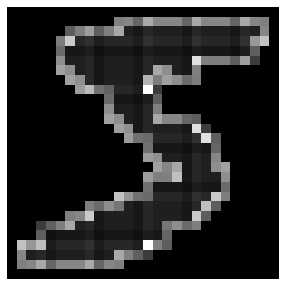

In [ ]:
# 샘플 이미지 출력
import matplotlib.pyplot as plt

def plot_image(data, idx):
  plt.figure(figsize = (5, 5))
  plt.imshow(data[idx], cmap = 'gray')
  plt.axis('off')
  plt.show()

plot_image(train_copy, 0)

In [ ]:
print(label[0])

5


  - 기존의 컬러 2차원 이미지가 흑백으로 잘 변환되었다.

### **4.1 KNN**

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [ ]:
knn = neighbors.KNeighborsClassifier().fit(train, label)
predicted_knn = knn.predict(test)

In [ ]:
submission['label'] = predicted_knn
submission.to_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/머신러닝 모델/knn.csv', index=False)

- **GridSearchCV**

In [ ]:
param_grid = {'n_neighbors' : range(1, 30, 2)}

grid_knn = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy')
grid_knn.fit(train, label)

print(grid_knn.best_params_)

{'n_neighbors': 5}


In [ ]:
pred_grid_knn = grid_knn.predict(test)
submission['label'] = pred_grid_knn
submission.to_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/머신러닝 모델/grid_knn.csv', index=False)

### **4.2 NB**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
nb_clf = MultinomialNB().fit(train,label)
predict = nb_clf.predict(test)

In [ ]:
submission['label'] = predict
submission.to_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/머신러닝 모델/nb.csv',index=False)

- **GridSearchCV**

In [ ]:
param = {'alpha': np.linspace(0.01,1,10)}

grid = GridSearchCV(estimator=nb_clf, param_grid=param, scoring='accuracy', cv=5, n_jobs=-1)
grid.fit(train,label)

print(grid.best_params_)

{'alpha': 0.56}


In [ ]:
grid_predict = grid.predict(test)
submission['label'] = grid_predict
submission.to_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/머신러닝 모델/grid_nb.csv',index=False)

### **4.3 SVM**

- **하이퍼 파라미터 튜닝**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

svm_clf = SVC(decision_function_shape = 'ovr', gamma = 'auto')
param_distributions = {'gamma' : reciprocal(0.001, 0.1), 'C' : uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter = 10, verbose = 2, cv = 3)
rnd_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=6.72065829799323, gamma=0.04374399374751307; total time= 5.1min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=6.72065829799323, gamma=0.04374399374751307; total time= 5.1min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......C=6.72065829799323, gamma=0.04374399374751307; total time= 4.6min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=1.068457276385917, gamma=0.023020412315218848; total time= 5.4min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=1.068457276385917, gamma=0.023020412315218848; total time= 5.4min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=1.068457276385917, gamma=0.023020412315218848; total time= 4.9min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=7.465026389776515, gamma=0.05958740854491974; total time= 5.6min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=7.465026389776515, gamma=0.05958740854491974; total time= 5.6min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=7.465026389776515, gamma=0.05958740854491974; total time= 5.3min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=7.489452055064001, gamma=0.0018352219143739532; total time= 5.6min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=7.489452055064001, gamma=0.0018352219143739532; total time= 5.6min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...C=7.489452055064001, gamma=0.0018352219143739532; total time= 5.4min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=6.483401562788335, gamma=0.05620603066860063; total time= 5.5min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=6.483401562788335, gamma=0.05620603066860063; total time= 5.5min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=6.483401562788335, gamma=0.05620603066860063; total time= 5.2min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=8.730704101921821, gamma=0.005415757703759005; total time= 4.4min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=8.730704101921821, gamma=0.005415757703759005; total time= 4.4min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=8.730704101921821, gamma=0.005415757703759005; total time= 4.0min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=2.067234590133035, gamma=0.08487093889979291; total time= 6.2min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=2.067234590133035, gamma=0.08487093889979291; total time= 6.2min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=2.067234590133035, gamma=0.08487093889979291; total time= 5.9min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1.9939530120240647, gamma=0.0077678191039331; total time= 5.6min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1.9939530120240647, gamma=0.0077678191039331; total time= 5.6min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=1.9939530120240647, gamma=0.0077678191039331; total time= 5.3min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=9.955980064057831, gamma=0.06056941765440218; total time= 5.6min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=9.955980064057831, gamma=0.06056941765440218; total time= 5.7min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....C=9.955980064057831, gamma=0.06056941765440218; total time= 5.3min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=9.723050316268454, gamma=0.002302092496730346; total time= 5.0min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=9.723050316268454, gamma=0.002302092496730346; total time= 5.0min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....C=9.723050316268454, gamma=0.002302092496730346; total time= 4.6min


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, estimator=SVC(gamma='auto'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff5f28a4df0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff5fa3fceb0>},
                   verbose=2)

In [ ]:
# 최적 파라미터 확인
rnd_search_cv.best_estimator_

SVC(C=2.067234590133035, gamma=0.08487093889979291)

In [ ]:
# 그때의 정확도 값
rnd_search_cv.best_score_

0.933479973146247

- **최적 파라미터를 활용한 모델 학습 및 예측**

In [ ]:
# 모델 학습
rnd_search_cv.best_estimator_.fit(X_train, y_train)

# 예측
y_pred = rnd_search_cv.best_estimator_.predict(test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- **최종 파일 제출**

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/원본 데이터/sample_submission.csv')
submission['label'] = y_pred

# 최종 파일 내보내기
submission.to_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/머신러닝 모델/svm.csv', index = False)

### **4.4 RF**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = { 
    'n_estimators': [10],
    'max_depth': [13, 14, 15, 16, 17],
    'criterion':['gini', 'entropy']
}

In [ ]:
rf_clf = RandomForestClassifier(random_state=42)

In [ ]:
rf_gc = GridSearchCV(rf_clf, param_grid, cv=3, verbose=2, scoring='accuracy')
rf_gc.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=13, n_estimators=10; total time=   2.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=13, n_estimators=10; total time=   2.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=13, n_estimators=10; total time=   2.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=14, n_estimators=10; total time=   2.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=14, n_estimators=10; total time=   2.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=14, n_estimators=10; total time=   2.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=15, n_estimators=10; total time=   2.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=15, n_estimators=10; total time=   2.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=15, n_estimators=10; total time=   2.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=16, n_estimators=10; total time=   2.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=16, n_estimators=10; total time=   2.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=16, n_estimators=10; total time=   2.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=17, n_estimators=10; total time=   2.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=17, n_estimators=10; total time=   2.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......criterion=gini, max_depth=17, n_estimators=10; total time=   2.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=13, n_estimators=10; total time=   3.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=13, n_estimators=10; total time=   3.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=13, n_estimators=10; total time=   3.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=14, n_estimators=10; total time=   3.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=14, n_estimators=10; total time=   3.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=14, n_estimators=10; total time=   3.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=15, n_estimators=10; total time=   3.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=15, n_estimators=10; total time=   3.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=15, n_estimators=10; total time=   3.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=16, n_estimators=10; total time=   3.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=16, n_estimators=10; total time=   3.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=16, n_estimators=10; total time=   3.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=17, n_estimators=10; total time=   3.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=17, n_estimators=10; total time=   3.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...criterion=entropy, max_depth=17, n_estimators=10; total time=   3.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [13, 14, 15, 16, 17],
                         'n_estimators': [10]},
             scoring='accuracy', verbose=2)

In [ ]:
rf_gc.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 10}

In [ ]:
pred_grid_rf = rf_gc.predict(test)
submission['label'] = pred_grid_rf
submission.to_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/머신러닝 모델/grid_rf.csv', index=False)

---

## **5. 딥러닝(1) : SimpleCNN**

### **5.0 전처리**

#### **1) 데이터 차원 확장 (Reshape)**

In [ ]:
# 모델링을 위해 데이터 차원 확장
X_train = train.reshape(-1, 28, 28, 1)
test = test.reshape(-1, 28, 28, 1)

In [ ]:
# 차원 확인
X_train.shape

(50000, 28, 28, 1)

#### **2) 라벨 인코딩 (One-Hot Encoding)**

In [ ]:
# train 라벨 값 인코딩
y_train = to_categorical(label)

print(f'Label size {y_train.shape}')

Label size (50000, 10)


### **5.1 모델 정의**

In [ ]:
model=Sequential()
  
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# 모델 요약
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)        

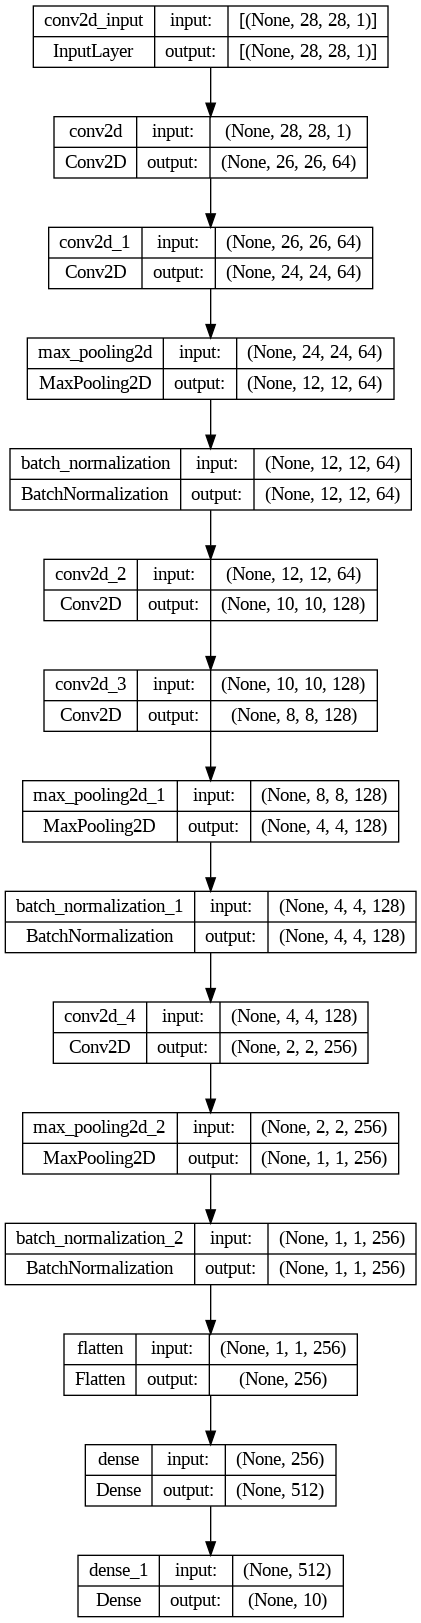

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='model.png')

### **5.2 데이터 증강**
  - 학습 데이터에 대한 과적합을 방지하기 위해 데이터 증강 실시
  - 이때, 수직 또는 수평으로 데이터를 대칭시키면 6과 9, 2와 5 등을 구분할 때 혼란을 야기할 수 있으므로 생략

In [ ]:
# 데이터 증강 진행 (과적합 방지)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

train_gen = datagen.flow(X_train,y_train, batch_size=64)
test_gen = datagen.flow(test, batch_size=64)

### **5.3 모델 학습**

In [ ]:
# 학습 파라미터 설정
epochs = 100
batch_size = 64
train_steps = X_train.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True,
     )

rp = keras.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [ ]:
# 모델 학습
history = model.fit(train_gen, 
                    epochs = epochs, 
                    steps_per_epoch = train_steps,
                    callbacks=[es, rp])

### **5.4 예측**

In [ ]:
# 각 클래스에 해당될 확률값 출력
y_pred = model.predict(test)

In [ ]:
# 확률값이 가장 높은 라벨로 분류
y_pred = np.argmax(y_pred, 1)

### **5.5 제출 파일 생성**

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/원본 데이터/sample_submission.csv')
submission['label'] = preds

# 파일 내보내기
submission.to_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/제출/SimpleCNN.csv', index = False)

---

## **6. 딥러닝(2) : SimpleCNN + KFold + tta**

  - `5. 딥러닝(1)`에서 진행한 모델의 한계를 보완하고자 K-fold, tta 기법을 추가로 적용하여 모델링을 진행하였다.
      1. K-fold
        - 학습 데이터에 대한 과적합을 방지하고자 cross validation 적용
      2. tta(test time augmentation)
        - 학습 데이터뿐만 아니라 테스트 데이터에도 데이터 증강(augmentation)을 적용하는 기법
        - 무작위로 회전된 테스트 데이터가 정확도를 높이는데 방해요소로 작용하므로, 테스트 데이터를 특정 각도로 회전함으로써 데이터의 학습률을 높이려는 시도

### **6.1 모델링**

In [ ]:
# 데이터 증강 진행 (과적합 방지)
from tqdm import tqdm

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
Y_train = label_df.drop('ID',axis=1)
labels = np.array(Y_train)
y_train_data = to_categorical(Y_train)

Epoch 1/100


<ipython-input-18-c8b74b579cec>:71: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


312/312 [==============================] - 19s 31ms/step - loss: 0.3731 - accuracy: 0.8795 - val_loss: 2.5627 - val_accuracy: 0.4137 - lr: 0.0010
Epoch 2/100
312/312 [==============================] - 10s 31ms/step - loss: 0.1606 - accuracy: 0.9485 - val_loss: 0.2267 - val_accuracy: 0.9261 - lr: 0.0010
Epoch 3/100
312/312 [==============================] - 8s 27ms/step - loss: 0.1326 - accuracy: 0.9571 - val_loss: 0.1572 - val_accuracy: 0.9511 - lr: 0.0010
Epoch 4/100
312/312 [==============================] - 8s 27ms/step - loss: 0.1204 - accuracy: 0.9614 - val_loss: 0.3221 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 5/100
312/312 [==============================] - 9s 27ms/step - loss: 0.1046 - accuracy: 0.9680 - val_loss: 0.1141 - val_accuracy: 0.9639 - lr: 0.0010
Epoch 6/100
312/312 [==============================] - 8s 27ms/step - loss: 0.0934 - accuracy: 0.9708 - val_loss: 0.1076 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 7/100
312/312 [==============================] - 10s 31ms/step

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-18-c8b74b579cec>:100: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(datagen.flow(test, batch_size=64, shuffle=False), steps = len(test)/64)
100%|██████████| 10/10 [01:48<00:00, 10.87s/it]


Epoch 1/100
312/312 [==============================] - 10s 31ms/step - loss: 0.3559 - accuracy: 0.8840 - val_loss: 3.7545 - val_accuracy: 0.1444 - lr: 0.0010
Epoch 2/100
312/312 [==============================] - 10s 31ms/step - loss: 0.1612 - accuracy: 0.9496 - val_loss: 0.1807 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 3/100
312/312 [==============================] - 8s 27ms/step - loss: 0.1266 - accuracy: 0.9604 - val_loss: 0.1608 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 4/100
312/312 [==============================] - 9s 30ms/step - loss: 0.1127 - accuracy: 0.9647 - val_loss: 0.1159 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 5/100
312/312 [==============================] - 9s 27ms/step - loss: 0.1009 - accuracy: 0.9688 - val_loss: 0.2050 - val_accuracy: 0.9363 - lr: 0.0010
Epoch 6/100
312/312 [==============================] - 9s 27ms/step - loss: 0.0929 - accuracy: 0.9713 - val_loss: 0.1408 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 7/100
311/312 [============================>.] - E

100%|██████████| 10/10 [02:05<00:00, 12.56s/it]


Epoch 1/100
312/312 [==============================] - 10s 29ms/step - loss: 0.3787 - accuracy: 0.8800 - val_loss: 3.6853 - val_accuracy: 0.2414 - lr: 0.0010
Epoch 2/100
312/312 [==============================] - 9s 28ms/step - loss: 0.1697 - accuracy: 0.9465 - val_loss: 0.8374 - val_accuracy: 0.7488 - lr: 0.0010
Epoch 3/100
312/312 [==============================] - 10s 31ms/step - loss: 0.1250 - accuracy: 0.9621 - val_loss: 0.1815 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 4/100
312/312 [==============================] - 8s 27ms/step - loss: 0.1211 - accuracy: 0.9618 - val_loss: 0.2233 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 5/100
312/312 [==============================] - 9s 27ms/step - loss: 0.1082 - accuracy: 0.9653 - val_loss: 0.1769 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 6/100
312/312 [==============================] - 9s 28ms/step - loss: 0.0915 - accuracy: 0.9715 - val_loss: 0.1534 - val_accuracy: 0.9517 - lr: 0.0010
Epoch 7/100
312/312 [==============================] - 9

100%|██████████| 10/10 [01:55<00:00, 11.57s/it]


Epoch 1/100
312/312 [==============================] - 9s 28ms/step - loss: 0.3690 - accuracy: 0.8782 - val_loss: 2.0845 - val_accuracy: 0.2718 - lr: 0.0010
Epoch 2/100
312/312 [==============================] - 8s 27ms/step - loss: 0.1594 - accuracy: 0.9478 - val_loss: 0.4501 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 3/100
312/312 [==============================] - 9s 28ms/step - loss: 0.1240 - accuracy: 0.9623 - val_loss: 0.1614 - val_accuracy: 0.9493 - lr: 0.0010
Epoch 4/100
312/312 [==============================] - 9s 28ms/step - loss: 0.1106 - accuracy: 0.9647 - val_loss: 0.1488 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 5/100
312/312 [==============================] - 9s 28ms/step - loss: 0.1060 - accuracy: 0.9657 - val_loss: 0.1534 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 6/100
312/312 [==============================] - 9s 27ms/step - loss: 0.0923 - accuracy: 0.9730 - val_loss: 0.1183 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 7/100
312/312 [==============================] - 9s 

100%|██████████| 10/10 [01:54<00:00, 11.47s/it]


Epoch 1/100
312/312 [==============================] - 10s 29ms/step - loss: 0.3704 - accuracy: 0.8800 - val_loss: 3.3258 - val_accuracy: 0.2642 - lr: 0.0010
Epoch 2/100
312/312 [==============================] - 8s 27ms/step - loss: 0.1650 - accuracy: 0.9482 - val_loss: 0.2210 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 3/100
312/312 [==============================] - 10s 31ms/step - loss: 0.1243 - accuracy: 0.9606 - val_loss: 0.1541 - val_accuracy: 0.9553 - lr: 0.0010
Epoch 4/100
312/312 [==============================] - 9s 28ms/step - loss: 0.1139 - accuracy: 0.9649 - val_loss: 0.1374 - val_accuracy: 0.9579 - lr: 0.0010
Epoch 5/100
312/312 [==============================] - 8s 27ms/step - loss: 0.0952 - accuracy: 0.9691 - val_loss: 0.1096 - val_accuracy: 0.9657 - lr: 0.0010
Epoch 6/100
312/312 [==============================] - 9s 28ms/step - loss: 0.0881 - accuracy: 0.9713 - val_loss: 0.1089 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 7/100
312/312 [==============================] - 1

100%|██████████| 10/10 [01:57<00:00, 11.71s/it]


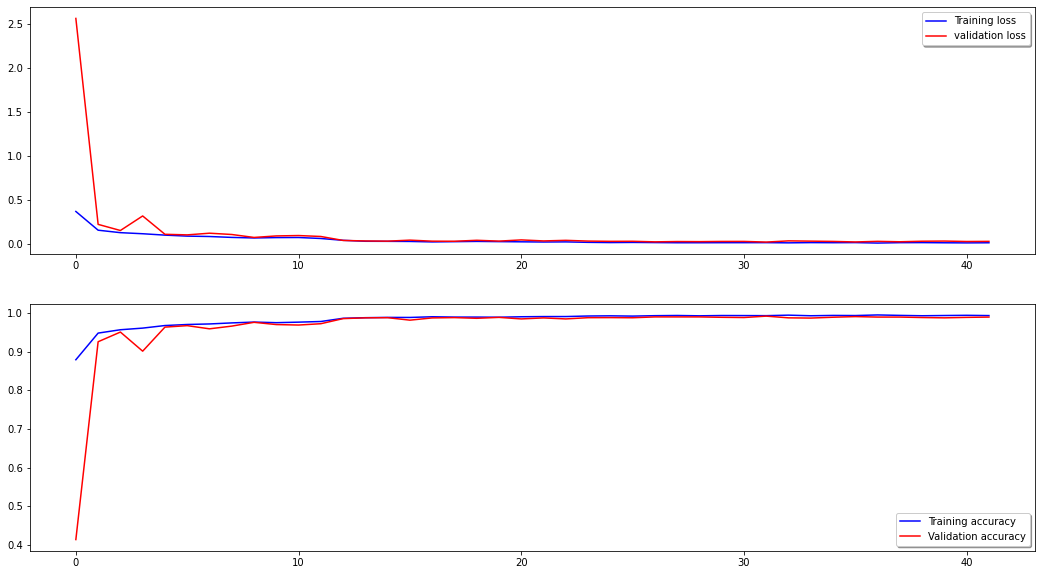

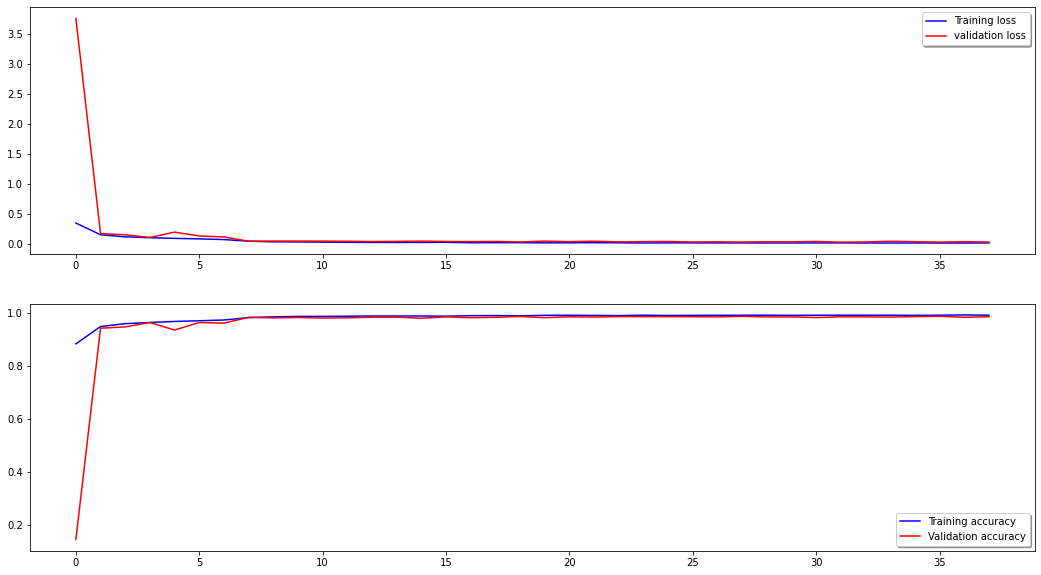

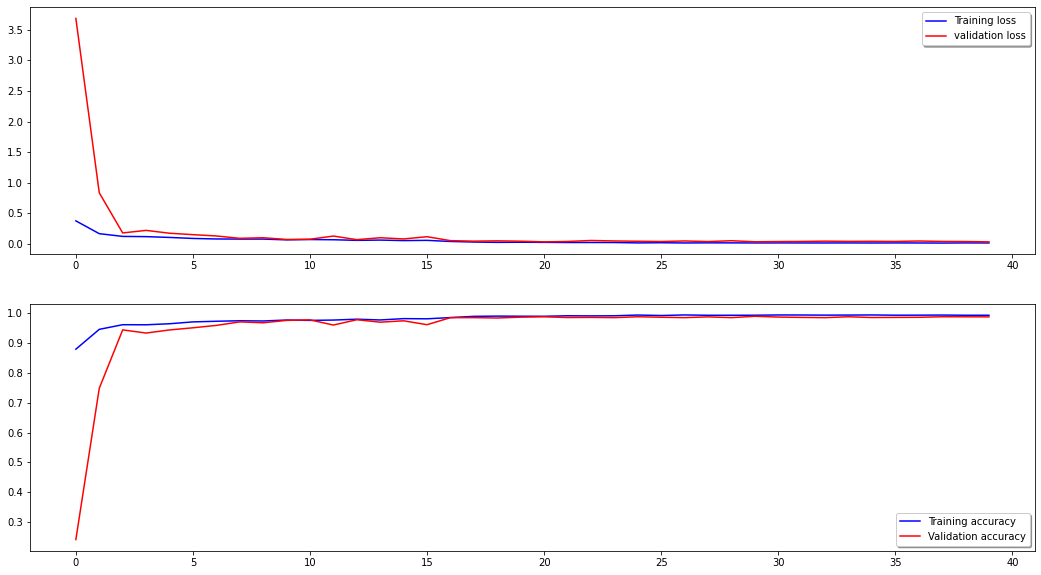

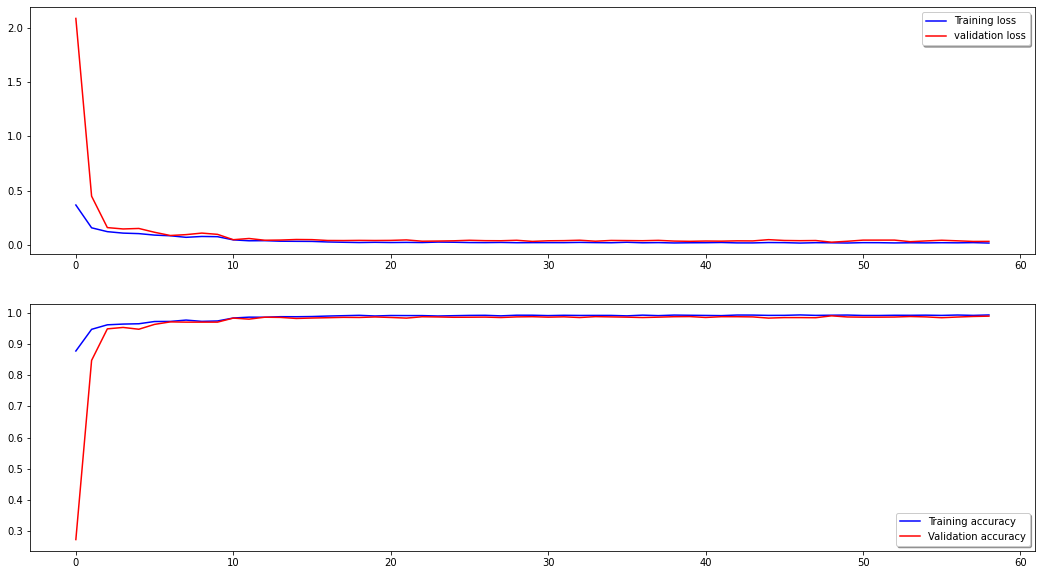

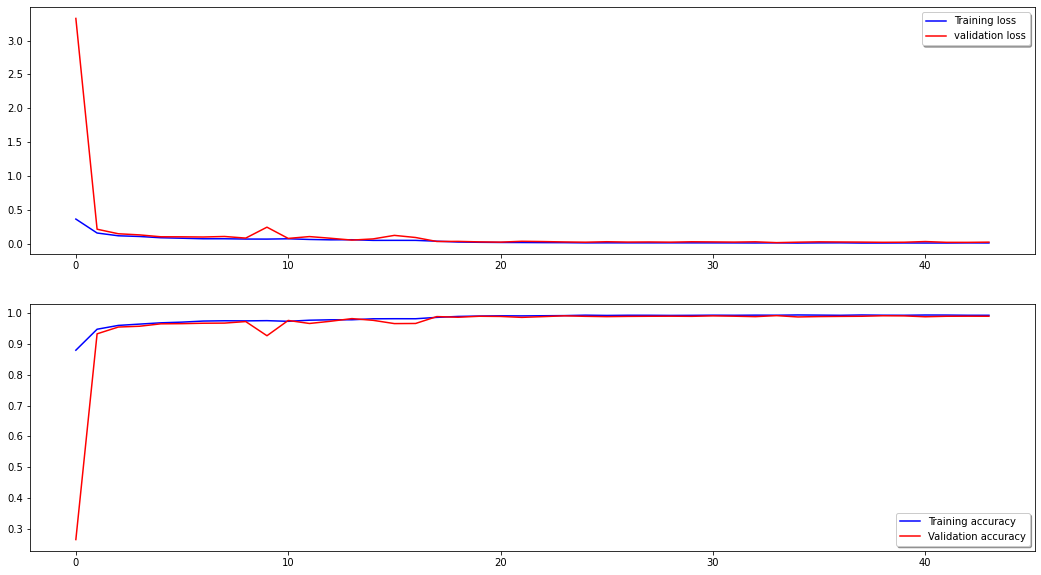

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)

all_score = []
all_preds = []
idx = 0

for train_index, valid_index in skf.split(X_train, labels):
    X_train_kfold, X_valid_kfold = X_train[train_index], X_train[valid_index]
    y_train_kfold, y_valid_kfold = y_train_data[train_index], y_train_data[valid_index]

    ''' 데이터 증강 '''
    datagen.fit(X_train_kfold)

    train_gen = datagen.flow(X_train_kfold, y_train_kfold, batch_size=64)
    valid_gen = datagen.flow(X_valid_kfold, y_valid_kfold, batch_size=64)


    ''' 모델 정의 '''
    model=Sequential()
  
    model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
    model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
    model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())    

    model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
        
    model.add(Flatten())
    model.add(Dense(512,activation="relu"))
        
    model.add(Dense(10,activation="softmax"))
        
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


    ''' 모델 훈련 '''
    # 학습 파라미터 설정
    epochs = 100
    batch_size = 128
    train_steps = X_train_kfold.shape[0] // batch_size
    valid_steps = X_valid_kfold.shape[0] // batch_size

    es = keras.callbacks.EarlyStopping(
            monitor="val_accuracy", # metrics to monitor
            patience=10, # how many epochs before stop
            verbose=1,
            mode="max", # we need the maximum accuracy.
            restore_best_weights=True,
        )

    rp = keras.callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",
            factor=0.2,
            patience=3,
            verbose=1,
            mode="max",
            min_lr=0.00001,
        )
    
    # 모델 학습
    history = model.fit_generator(train_gen, 
                                epochs = epochs, 
                                steps_per_epoch = train_steps,
                                validation_data = valid_gen,
                                validation_steps = valid_steps, 
                                callbacks=[es, rp])
    
    # 모델 저장
    model.save('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/딥러닝/kfold_tta_model_' + str(idx) + '_lastEpoch.h5')
    idx += 1

    # 학습/검증 데이터셋에서의 loss, accuracy 그래프 출력 
    fig, ax = plt.subplots(2,1, figsize=(18, 10))
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

    scores = model.evaluate(valid_gen)
    all_score.append(scores)

    ''' 예측 '''
    # tta
    tta_steps = 10
    predictions = []

    for i in tqdm(range(tta_steps)):
        preds = model.predict_generator(datagen.flow(test, batch_size=64, shuffle=False), steps = len(test)/64)
        predictions.append(preds)

    pred = np.argmax(np.mean(predictions, axis=0), axis=1)
    all_preds.append(pred)
    
    # 파일 내보내기
    submission = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/원본 데이터/sample_submission.csv')
    submission['label'] = pred
    submission.to_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/제출/kfold_tta' + str(idx) + '.csv', index = False)

### **6.2 예측 (Hard Voting)**

In [ ]:
pred1 = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/제출/kfold_tta1.csv')
pred2 = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/제출/kfold_tta2.csv')
pred3 = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/제출/kfold_tta3.csv')
pred4 = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/제출/kfold_tta4.csv')
pred5 = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/제출/kfold_tta5.csv')

In [ ]:
total_preds = pd.concat([pred1, pred2, pred3, pred4, pred5], axis=1)
total_preds.drop('ID', axis=1, inplace=True)
total_preds

,label,label,label,label,label
0,4,4,4,5,4
1,7,7,7,7,7
2,2,2,2,2,2
3,4,4,4,4,4
4,9,9,9,9,9
...,...,...,...,...,...
39995,5,5,5,5,8
39996,4,4,4,4,4
39997,4,4,4,4,4
39998,5,5,5,5,5


In [ ]:
final_pred = list(map(int, total_preds.mode(axis=1).iloc[:,0]))
final_pred

[4,
 7,
 2,
 4,
 9,
 9,
 0,
 1,
 4,
 5,
 4,
 7,
 1,
 4,
 7,
 0,
 4,
 9,
 2,
 1,
 6,
 5,
 3,
 9,
 1,
 8,
 5,
 8,
 3,
 7,
 6,
 0,
 7,
 1,
 6,
 5,
 5,
 7,
 4,
 3,
 0,
 3,
 8,
 1,
 4,
 8,
 8,
 3,
 2,
 3,
 5,
 9,
 6,
 5,
 4,
 9,
 3,
 5,
 8,
 6,
 8,
 1,
 2,
 5,
 1,
 4,
 2,
 7,
 6,
 5,
 6,
 3,
 3,
 3,
 7,
 2,
 5,
 8,
 7,
 0,
 1,
 7,
 8,
 8,
 2,
 1,
 1,
 7,
 6,
 2,
 2,
 6,
 8,
 0,
 6,
 3,
 4,
 5,
 5,
 2,
 8,
 7,
 0,
 0,
 8,
 2,
 2,
 6,
 5,
 8,
 2,
 0,
 9,
 8,
 4,
 2,
 8,
 3,
 8,
 1,
 2,
 3,
 7,
 4,
 5,
 2,
 6,
 8,
 6,
 1,
 4,
 9,
 7,
 8,
 1,
 0,
 2,
 2,
 9,
 9,
 1,
 6,
 5,
 5,
 3,
 6,
 8,
 6,
 8,
 0,
 0,
 5,
 8,
 5,
 7,
 3,
 1,
 8,
 5,
 4,
 2,
 4,
 4,
 1,
 4,
 6,
 8,
 4,
 4,
 1,
 1,
 2,
 5,
 1,
 9,
 7,
 9,
 0,
 7,
 7,
 8,
 9,
 0,
 8,
 0,
 6,
 5,
 3,
 1,
 0,
 4,
 5,
 6,
 1,
 6,
 5,
 5,
 6,
 6,
 3,
 2,
 1,
 1,
 6,
 1,
 7,
 5,
 1,
 1,
 5,
 8,
 8,
 1,
 6,
 6,
 0,
 0,
 1,
 8,
 9,
 8,
 2,
 2,
 3,
 7,
 2,
 1,
 5,
 8,
 6,
 1,
 6,
 4,
 3,
 0,
 5,
 0,
 9,
 9,
 6,
 6,
 2,
 0,
 7,
 4,
 7,
 4,
 3,
 3,
 4,


### **6.3 제출 파일 생성**

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/원본 데이터/sample_submission.csv')
submission['label'] = final_pred

# 파일 내보내기
submission.to_csv('/content/drive/MyDrive/ESAA OB 4조/방학 프로젝트/모델링/제출/kfold_tta_final4.csv', index = False)